# 3장 케라스와 텐서플로우

__감사말__: 프랑소와 숄레의 [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) 3장에 사용된 코드에 대한 설명을 담고 있으며 텐서플로우 2.6 버전에서 작성되었습니다. 소스코드를 공개한 저자에게 감사드립니다.

__구글 코랩 설정__: '런타임 -> 런타임 유형 변경' 메뉴에서 GPU를 지정한다.
이후 아래 명령어를 실행했을 때 오류가 발생하지 않으면 필요할 때 GPU가 자동 사용된다.

```
!nvidia-smi
```

구글 코랩에서 사용되는 tensorflow 버전을 확인하려면 아래 명령문을 실행한다.

```python
import tensorflow as tf
tf.__version__
```

tensorflow가 GPU를 사용하는지 여부를 알고 싶으면 
주피터 노트북 등 사용하는 편집기 및 파이썬 터미널에서 아래 명령문을 실행한다.

```python
import tensorflow as tf
tf.config.list_physical_devices('GPU')
```

## 주요 내용

- 딥러닝 필수 요소
- 케라스와 텐서플로우 간략 소개
- 텐서플로우, 케라스, GPU를 활용한 딥러닝 작업환경
- 케라스와 텐서플로우를 이용한 신경망의 핵심 구성요소 구현

## 3.5 텐서플로우 기본 사용법

### 신경망 모델 훈련 핵심 1: 텐서플로우 기본 API 활용 텐서 조작

1. 상수 텐서와 변수 텐서
    - 상수 텐서(constant tensor): 입출력 데이터 등 변하지 않는 텐서
    - 변수 텐서(variable): 모델 가중치, 편향 등 업데이트 되는 텐서
1. 텐서 연산: 덧셈, relu, 점곱 등
1. 역전파(backpropagation): 
    - 손실함수의 그레이디언트 계산 후 모델 가중치 업데이트
    - 그레이디언트 테이프(`GradientTape`) 이용

### 신경망 모델 훈련 핵심 2: 케라스 API 활용 모델 구성 및 훈련

1. 층(layer)과 모델: 층을 적절하게 쌓아 모델 구성
1. 손실 함수(loss function): 학습 방향을 유도하는 피드백 역할 수행
1. 옵티마이저(optimizer): 학습 방향을 정하는 기능 수행
1. 메트릭(metric): 정확도 등 모델 성능 평가 용도
1. 훈련 반복(training loop): 미니 배치 경사하강법 실행

### 텐서플로우 기본 API 활용법

In [1]:
import tensorflow as tf

#### 상수 텐서

상수 텐서는 한 번 생성되면 값을 수정할 수 없다.
딥러닝 연산에 많이 사용되는 상수 텐서는 다음과 같다.

- 상수 텐서 수동 생성

In [2]:
x = tf.constant([[1., 2.], [3., 4.]])
print(x)

tf.Tensor(
[[1. 2.]
 [3. 4.]], shape=(2, 2), dtype=float32)


- 1로만 이루어진 텐서

In [3]:
x = tf.ones(shape=(2, 1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


- 0으로만 이루어진 텐서

In [4]:
x = tf.zeros(shape=(2, 1))
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


- `normal()` 함수: 0과 1사이의 부동소수점을 정규분포를 따르도록 무작위적으로 선택
    - `mean`: 평균값
    - `stddev`: 표준편차

In [5]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

tf.Tensor(
[[0.3118824]
 [0.922155 ]
 [2.184284 ]], shape=(3, 1), dtype=float32)


- `uniform()` 함수: 지정된 구간에서 부동소수점을 균등분포를 따르도록 무작위적으로 선택
    - `minval`: 구간 최솟값
    - `maxval`: 구간 최댓값

In [6]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.02995241]
 [0.554219  ]
 [0.9217409 ]], shape=(3, 1), dtype=float32)


한 번 생성된 상수 텐서는 수정이 불가능하다. 

In [7]:
x[0, 0] = 1.0

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

In [8]:
x[0, 0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.029952407>

In [9]:
type(x[0, 0])

tensorflow.python.framework.ops.EagerTensor

넘파이 어레이는 반면에 수정 가능하다.

In [10]:
import numpy as np

x = np.ones(shape=(2, 2))

x[0, 0] = 0.0
print(x)

[[0. 1.]
 [1. 1.]]


#### 변수 텐서

신경망 모델 훈련 도중에 가중치 텐서는 업데이트될 수 있어야 한다.
이런 텐서는 변수 텐서로 선언해야 하며, 
`Variaible` 클래스로 감싼다.

In [11]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.7599942],
       [-1.453185 ],
       [ 0.5086566]], dtype=float32)>


`Variable` 클래스의 `assign()` 메서드를 활용하여 텐서 항목 전체 또는 
일부를 수정할 수 있다.

In [12]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

__주의사항__: 모양(shape)이 동일한 텐서를 사용해야 한다.

In [13]:
v.assign(tf.ones((3, 2)))

ValueError: Cannot assign to variable Variable:0 due to variable shape (3, 1) and value shape (3, 2) are incompatible

특정 항목을 수정하려면 인덱싱과 함께 사용한다.

In [14]:
v[0, 0]

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [15]:
type(v[0, 0])

tensorflow.python.framework.ops.EagerTensor

상수 텐서의 경우처럼 각 항목은 `EagerTensor` 객체이지만 이번엔 항목 변환이 가능하다.
텐서플로우 내부에서 변수 텐서인 경우와 아닌 경우를 구분해서 `assign()` 메서드의 지원여부를 
판단하는 것으로 보인다.

In [16]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

`assign_add()` 메서드는 변수 텐서에 대한 덧셈 연산을 수행한다.
단, 해당 객체의 항목이 업데이트된다.

In [17]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

#### 텐서 연산

텐서 연산은 넘파이 어레이에 대한 연산과 거의 같다.
다음은 몇 가지 예제를 보여준다.

__참고__: 보다 다양한 텐서와 텐서 연산에 대한 자세한 설명은 [텐서플로우 가이드(TensorFlow Guide)](https://www.tensorflow.org/guide/tensor) 영어판을 참고하라.

In [18]:
import numpy as np

a = np.array([[2., 1.],
              [3., -2.]], dtype=np.float32)

In [19]:
a = tf.convert_to_tensor(a)
a += tf.ones((2, 2))
print(a)

tf.Tensor(
[[ 3.  2.]
 [ 4. -1.]], shape=(2, 2), dtype=float32)


In [20]:
b = tf.square(a)
print(b)

tf.Tensor(
[[ 9.  4.]
 [16.  1.]], shape=(2, 2), dtype=float32)


In [21]:
c = tf.sqrt(a)
print(c)

tf.Tensor(
[[1.7320508 1.4142135]
 [2.              nan]], shape=(2, 2), dtype=float32)


In [22]:
a = tf.nn.relu(a)
print(a)

tf.Tensor(
[[3. 2.]
 [4. 0.]], shape=(2, 2), dtype=float32)


In [23]:
c = tf.sqrt(a)
print(c)

tf.Tensor(
[[1.7320508 1.4142135]
 [2.        0.       ]], shape=(2, 2), dtype=float32)


In [24]:
d = b + c
print(d)

tf.Tensor(
[[10.732051   5.4142137]
 [18.         1.       ]], shape=(2, 2), dtype=float32)


`matmul()` 곱셈은 넘파이의 점곱(dot) 연산자와 유사하게 작동하며
2차원 행렬모양의 텐서의 경우 행렬 곱으로 실행된다.

In [25]:
e = tf.matmul(a, b)
print(e)

tf.Tensor(
[[59. 14.]
 [36. 16.]], shape=(2, 2), dtype=float32)


곱셈 연산자(`*`)는 항목별 곱셈으로 처리된다.

In [26]:
e *= a
print(e)

tf.Tensor(
[[177.  28.]
 [144.   0.]], shape=(2, 2), dtype=float32)


### `GradientTape` API (다시 살펴 보기)

그레이디언트 테이프는 텐서 변수에 의존하는 미분함수의 그레이디언트를 자동 계산해준다.
아래 코드는 제곱 함수의 미분을 계산한다.

$$
f(x) = x^2 \quad \Longrightarrow \quad \nabla f(x) = \frac{df(x)}{dx} = 2x
$$

In [27]:
input_var = tf.Variable(initial_value=3.)

with tf.GradientTape() as tape:
    result = tf.square(input_var)

gradient = tape.gradient(result, input_var)

print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


그레이디언트 테이프 기능을 이용하여 신경망 모델 훈련 중에
손실 함수의 그레이디언트를 계산한다.

```python
gradient = tape.gradient(loss, weights)
```

- `loss`: `weights` 텐서 변수에 의존하는 손실 함수
- `weights`: 가중치 어레이

상수 텐서에 대해 그레이디언트 테이프를 이용하려면 `tape.watch()` 메서드로 감싸야 한다.

In [28]:
input_const = tf.constant(3.)

with tf.GradientTape() as tape:
    tape.watch(input_const)
    result = tf.square(input_const)

gradient = tape.gradient(result, input_const)

print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


__참고__: 2차 미분도 가능하지만 여기서는 관심 대상이 아니다.

```python
time = tf.Variable(0.)

with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position =  4.9 * time ** 2
    speed = inner_tape.gradient(position, time)

acceleration = outer_tape.gradient(speed, time)
```

### 저수준 선형 분류 신경망 구현

순수 텐서플로우 API만을 이용하여 선형 분류 신경망을 구현한다.

#### 데이터셋 생성

- `np.random.multivariate_normal()`
    - 다변량 정규분포를 따르는 데이터 생성
    - 평균값과 공분산 지정 필요
- 음성 데이터셋
    - 샘플 수: 1,000
    - 평균값: `[0, 3]`
    - 공분산: `[[1, 0.5],[0.5, 1]]`
- 양성 데이터셋
    - 샘플 수: 1,000
    - 평균값: `[3, 0]`
    - 공분산: `[[1, 0.5],[0.5, 1]]`

In [29]:
num_samples_per_class = 1000

# 음성 데이터셋
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)

# 양성 데이터셋
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)

두 개의 `(1000, 2)` 모양의 양성, 음성 데이터셋을 하나의 `(2000, 2)` 모양의 데이터셋으로 합치면서
동시에 자료형을 `np.float32`로 지정한다. 
자료형을 지정하지 않으면 `np.float64`로 지정되어 보다 많은 메모리와 실행시간을 요구한다.

In [30]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

음성 샘플의 타깃은 0, 양성 샘플의 타깃은 1로 지정한다.

In [31]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

양성, 음성 샘플을 색깔로 구분하면 다음과 같다.

- `inputs[:, 0]`: x 좌표
- `inputs[:, 1]`: x 좌표
- `c=targets[:, 0]`: 0 또는 1에 따른 색상 지정

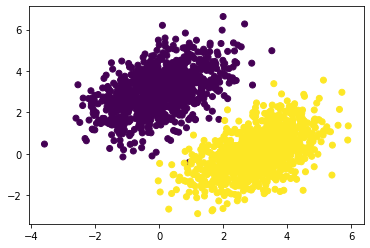

In [32]:
import matplotlib.pyplot as plt

plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

#### 가중치 변수 텐서 생성

In [33]:
input_dim = 2     # 입력 샘플의 특성이 2개
output_dim = 1    # 하나의 값으로 출력

# 가중치: 무작위 초기화
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))

# 편향: 0으로 초기화
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

#### 예측 모델(함수) 선언

아래 함수는 하나의 층만 사용하는 모델이 출력값을 계산하는 과정이다.

In [34]:
def model(inputs):
    return tf.matmul(inputs, W) + b

#### 손실 함수: 평균 제곱 오차(MSE)

- `tf.reduce_mean()`: 텐서에 포함된 항목들의 평균값 계산.
    넘파이의 `np.mean()`과 결과는 동일하지만 텐서플로우의 텐서를 대상으로 함.

In [35]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

#### 훈련 단계

하나의 배치에 대해 예측값을 계산한 후에 손실 함수의 그레이디언트를 이용하여 가중치와 편향을 업데이트한다. 

In [36]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

#### 배치 훈련

배치 훈련을 총 40번 반복한다.

In [37]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 0.5027
Loss at step 1: 0.0792
Loss at step 2: 0.0715
Loss at step 3: 0.0671
Loss at step 4: 0.0634
Loss at step 5: 0.0602
Loss at step 6: 0.0572
Loss at step 7: 0.0544
Loss at step 8: 0.0519
Loss at step 9: 0.0497
Loss at step 10: 0.0476
Loss at step 11: 0.0457
Loss at step 12: 0.0439
Loss at step 13: 0.0423
Loss at step 14: 0.0408
Loss at step 15: 0.0395
Loss at step 16: 0.0383
Loss at step 17: 0.0371
Loss at step 18: 0.0361
Loss at step 19: 0.0352
Loss at step 20: 0.0343
Loss at step 21: 0.0335
Loss at step 22: 0.0328
Loss at step 23: 0.0321
Loss at step 24: 0.0315
Loss at step 25: 0.0309
Loss at step 26: 0.0304
Loss at step 27: 0.0300
Loss at step 28: 0.0295
Loss at step 29: 0.0292
Loss at step 30: 0.0288
Loss at step 31: 0.0285
Loss at step 32: 0.0282
Loss at step 33: 0.0279
Loss at step 34: 0.0276
Loss at step 35: 0.0274
Loss at step 36: 0.0272
Loss at step 37: 0.0270
Loss at step 38: 0.0268
Loss at step 39: 0.0267


#### 예측

In [38]:
predictions = model(inputs)

예측 결과를 확인하면 다음과 같다.
예측값이 0.5보다 클 때 양성으로 판정한다.

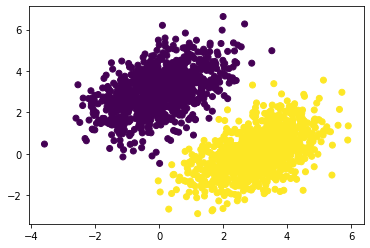

In [39]:
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

결정 경계를 직선으로 그리면 다음과 같다.

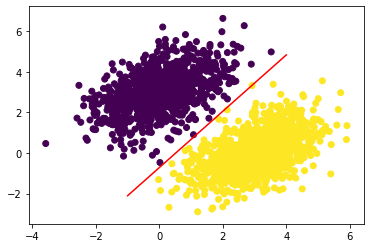

In [40]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]

plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

## 3.6 케라스의 핵심 API 이해

### 층

층(layer)의 역할은 다음과 같다.

- 모델의 상태(지식)로 사용되는 가중치(weight)와 편향(bias) 저장
- 데이터 표현 변환(forwardd pass)

층은 사용되는 클래스에 따라 다양한 형식의 텐서를 취급한다.

- `Dense` 클래스를 사용하는 밀집층(dense layer): 
    `(샘플수, 특성수)` 모양의 2D 텐서로 제공된 데이터셋
- `LSTM` 클래스, `Conv1D` 클래스 등을 사용하는 순환층(recurrent layer): 
    `(샘플수, 타임스텝수, 특성수)` 모양의 3D 텐서로 제공된 순차 데이터셋
- `Cons2D` 클래스 등을 사용하는 층: 
    `(샘플수, 가로, 세로, 채널수)` 모양의 4D 텐서로 제공된 이미지 데이터셋
    
케라스를 활용하여 딥러닝 모델을 구성하는 것은 호환 가능한 층들을 적절하게 연결하여 층을 쌓는 것을 의미한다.

#### `Layer` 클래스

케라스에서 사용되는 모든 층 클래스는 `Layer` 클래스를 상속하며,
이를 통해 상속받는 `__call__()` 메서드가 
가중치와 편향 벡터를 생성 및 초기화하고 입력 데이터를 출력 데이터로 변환하는 일을 수행한다.

`Layer` 클래스에서 선언된 `__call__()` 메서드가 하는 일을 간략하게 나타내면 다음과 같다. 

--- 
```python
def __call__(self, inputs):
    if not self.built:
        self.build(inputs.shape)
        self.built = True
return self.call(inputs)
```
---

위 코드에 사용된 인스턴스 변수와 메서드는 다음과 같다. 

- `self.built`: 가중치와 편향 벡터가 초기화가 되어 있는지 여부 기억
- `self.build(inputs.shape)`: 입력 배치 데이터셋(`inputs`)의 모양(shape) 정보를 이용하여 
    적절한 모양의 가중치 텐서와 편향 텐서를 생성하고 초기화한다.
    - 가중치 텐서 초기화: 무작위적(`random_normal`)
    - 편향 텐서 초기화: 0 벡터(`zeros`)
- `self.call(inputs)`: 출력값 계산(forward pass)
    - 아핀 변환 및 활성화 함수 적용
    
즉, 지정된 층이 입력값을 받아 출력값을 계산해야 할 때 
가장 먼저 입력값의 모양을 보고 가중치 텐서와 편향 텐서를 초기화하며,
그 다음에 출력값을 계산한다. 

이런 이유로 2장에서 살펴본 MNIST 모델 사용된 `Dense` 클래스는 입력 데이터에 정보를 요구하지 않는다.

---
```python
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
```
---

위 설명을 바탕으로 해서 `Dense` 클래스와 유사하게 작동하는 
`SimpleDense` 클래스를 직접 정의하려면 
`build()` 메서드와 `call()` 메서드를 아래와 같이 구현하면 된다.
두 메서드의 정의에 사용된 매개변수와 메서드는 다음과 같다.

- `units`: 변환된 출력 샘플의 특성수 지정
- `activation`: 활성화 함수 지정
- `input_shape`: 입력 배치의 2D 모양. 따라서 둘째 항목이 입력 샘플의 특성 수임.
- `add_weight(모양, 초기화방법)`: 지정된 모양의 텐서 생성 및 초기화. `Layer` 클래스에서 상속.

In [41]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

`SimpleDense` 층 하나로 이루어진 모델이 작동하는 방식은 다음과 같다.

- 모델 구성: 생성자에 의해 출력 샘플의 특성수와 활성화 함수 지정

In [42]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)

- 입력 데이터셋 지정: 입력 샘플 하나의 특성수는 784. 샘플 수는 2.

In [43]:
input_tensor = tf.ones(shape=(2, 784))

- 출력값 생성: `__call__()` 메서드 실행. 
    - 가중치 텐서 `W` 생성 및 초기호: `(784, 32)`
    - 편향 텐서 `b` 생성 및 초기호: `(32, )`
    - 생성된 가중치와 편향을 이용하여 출력값 계산(아핀 변환 및 활성화 함수 적용)

In [44]:
output_tensor = my_dense(input_tensor)

print(output_tensor.shape)

(2, 32)


### From layers to models

In [45]:
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(10, activation="softmax")
])

### The "compile" step: configuring the learning process

In [46]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])

In [47]:
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

### Picking a loss function

### Understanding the `fit` method

**Calling `fit` with NumPy data**

In [48]:
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128
)

Epoch 1/5
16/16 [==============================] - 0s 814us/step - loss: 15.4181 - binary_accuracy: 0.5400
Epoch 2/5
16/16 [==============================] - 0s 811us/step - loss: 14.7891 - binary_accuracy: 0.5430
Epoch 3/5
16/16 [==============================] - 0s 655us/step - loss: 14.2571 - binary_accuracy: 0.5470
Epoch 4/5
16/16 [==============================] - 0s 792us/step - loss: 13.7461 - binary_accuracy: 0.5475
Epoch 5/5
16/16 [==============================] - 0s 897us/step - loss: 13.2406 - binary_accuracy: 0.5500


In [49]:
history.history

{'loss': [15.418089866638184,
  14.789077758789062,
  14.257124900817871,
  13.746149063110352,
  13.240589141845703],
 'binary_accuracy': [0.5400000214576721,
  0.5429999828338623,
  0.546999990940094,
  0.5475000143051147,
  0.550000011920929]}

### Monitoring loss & metrics on validation data

**Using the validation data argument**

In [50]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/5
88/88 [==============================] - 0s 2ms/step - loss: 0.1017 - binary_accuracy: 0.9414 - val_loss: 0.1458 - val_binary_accuracy: 0.9183
Epoch 2/5
88/88 [==============================] - 0s 849us/step - loss: 0.0687 - binary_accuracy: 0.9650 - val_loss: 0.0365 - val_binary_accuracy: 0.9933
Epoch 3/5
88/88 [==============================] - 0s 866us/step - loss: 0.0744 - binary_accuracy: 0.9571 - val_loss: 0.0978 - val_binary_accuracy: 0.9817
Epoch 4/5
88/88 [==============================] - 0s 887us/step - loss: 0.0825 - binary_accuracy: 0.9407 - val_loss: 0.2379 - val_binary_accuracy: 0.7950
Epoch 5/5
88/88 [==============================] - 0s 845us/step - loss: 0.0671 - binary_accuracy: 0.9607 - val_loss: 0.1211 - val_binary_accuracy: 0.8200


### Inference: using a model after training

In [51]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

[[ 0.5973935 ]
 [ 0.79232895]
 [ 0.8469417 ]
 [ 0.52738994]
 [ 0.7281772 ]
 [ 0.07958806]
 [-0.09605762]
 [ 0.41088825]
 [ 0.30025807]
 [ 0.10596478]]
